In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [5]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

nue = uproot.open("root_files/nue_new.root")[fold][tree]
variables = [
    "proton_e", "isVtxInFiducial", "npion", "mc_pdg", "mc_vx", "mc_vy", "elec_e",
    "mc_vz", "mc_endx", "mc_endy", "mc_endz", "selected", "shr_hits_tot", "trk_hits_tot", "nu_e", "category",
    "slpdg"
]
nue = nue.pandas.df(variables, flatten=False)

In [6]:
def is_fidvol(x, y, z):
    return (x + 10 < 256) & (x - 10 > 0) & (y + 15 < 116.5) & (
        y - 15 > -116.5) & (z - 10 > 0) & (z + 50 < 1046.5)


def is_fiducial(x, y, z):
    try:
        x_1 = x[:, 0] > 10
        x_2 = x[:, 1] > 10
        y_1 = y[:, 0] > 15
        y_2 = y[:, 1] > 15
        z_1 = z[:, 0] > 10
        z_2 = z[:, 1] > 50

        return x_1 & x_2 & y_1 & y_2 & z_1 & z_2
    except IndexError:
        return True


def true_selection(sample):

    mc_pdg = sample["mc_pdg"].ravel()
    mc_vx = sample["mc_vx"].ravel()
    mc_vy = sample["mc_vy"].ravel()
    mc_vz = sample["mc_vz"].ravel()
    mc_endx = sample["mc_endx"].ravel()
    mc_endy = sample["mc_endy"].ravel()
    mc_endz = sample["mc_endz"].ravel()

    mc_p_v = [
        is_fidvol(vx[np.where(pdg == 2212)], vy[np.where(pdg == 2212)],
                  vz[np.where(pdg == 2212)])
        for pdg, vx, vy, vz in zip(mc_pdg, mc_vx, mc_vy, mc_vz)
    ]

    mc_p_e = [
        is_fidvol(ex[np.where(pdg == 2212)], ey[np.where(pdg == 2212)],
                  ez[np.where(pdg == 2212)])
        for pdg, ex, ey, ez in zip(mc_pdg, mc_endx, mc_endy, mc_endz)
    ]

    mc_elec_v = [
        is_fidvol(vx[np.where(pdg == 11)], vy[np.where(pdg == 11)],
                  vz[np.where(pdg == 11)])
        for pdg, vx, vy, vz in zip(mc_pdg, mc_vx, mc_vy, mc_vz)
    ]

    mc_p_is_fidvol = [all(v) and all(e) for v, e in zip(mc_p_v, mc_p_e)]
    mc_elec_is_fidvol = [all(e) for e in mc_elec_v]

    sample["mc_p_is_fidvol"] = mc_p_is_fidvol
    sample["mc_e_is_fidvol"] = mc_elec_is_fidvol

    true_selection = sample.query(
        "mc_e_is_fidvol == True & mc_p_is_fidvol == True & (proton_e - 0.938) > 0.04 & (elec_e - 0.052) > 0.03 & isVtxInFiducial == True & npion == 0"
    )

    return true_selection


def reco_selection_2(sample):
    selected = sample.query(
        "selected == 1 & slpdg==12"
    )  # & shr_hits_tot > 5 & trk_hits_tot > 5 & category == 11")
    return selected


def efficiency(sample, true_selection, reco_selection, variable,
               **hist_options):

    true_selected = true_selection(sample)
    reco_selected = reco_selection(true_selected)
    den, bins = np.histogram(true_selected[variable], **hist_options)
    num, bins = np.histogram(reco_selected[variable], **hist_options)

    err = 1 / den * np.sqrt(num * (1 - num / den))

    return num, den, err, bins


def efficiency_plot(ax,
                    sample,
                    true_selection,
                    reco_selection,
                    variable,
                    label='',
                    **hist_options):
    num, den, err, bins = efficiency(sample, true_selection, reco_selection,
                                     "nu_e", **hist_options)
    eff = num / den
    bincenters = 0.5 * (bins[1:] + bins[:-1])

    eff = ax.errorbar(
        bincenters,
        eff,
        yerr=err,
        xerr=0.075,
        fmt='none',
        label='%s: %.1f%%' % (label, sum(num) / sum(den) * 100))

    return eff

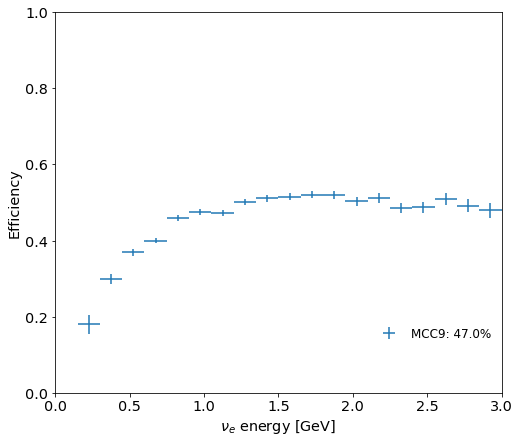

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

# eff2 = efficiency_plot(
#     ax,
#     nue,
#     true_selection,
#     reco_selection_1,
#     "nu_e",
#     label=r"MCC9: 1 shower + 1 track",
#     range=(0, 3),
#     bins=20)


eff2 = efficiency_plot(
    ax,
    nue,
    true_selection,
    reco_selection_2,
    "nu_e",
    label=r"MCC9",
    range=(0, 3),
    bins=20)

leg = ax.legend(loc='bottom right', bbox_to_anchor=(1, 0.2), frameon=False)

ax.set_ylim(0, 1)
ax.set_xlim(0, 3)
ax.set_ylabel("Efficiency")
ax.set_xlabel(r"$\nu_e$ energy [GeV]")

fig.savefig("plots/eff.pdf", transparent=True)